In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20
IMG_SIZE = 256

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/tomatoDS",
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode= 'rgb'
)

Found 300 files belonging to 2 classes.


In [ ]:
def test_train_spilit(dataset, train_size = 0.8, test_size = 0.1, val_size = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 12)

    train_ds = dataset.take(int(ds_size*train_size))
    val_ds = dataset.skip(int(ds_size*train_size)).take(int(ds_size*val_size))
    test_ds = dataset.skip(int(ds_size*train_size)).skip(int(ds_size*val_size))

    return train_ds, val_ds, test_ds

In [ ]:
names  = dataset.class_names
print(names)

['Tomato__Target_Spot', 'Tomato_healthy']


In [ ]:
train_ds, val_ds, test_ds = test_train_spilit(dataset)

In [ ]:
train_ds  = train_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds  = val_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize =  tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
])

In [ ]:
data_augmentation =  tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    # layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
])

In [ ]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)
# input_tensor = tf.keras.Input(shape=INPUT_SHAPE)
NUM_CLASSES = len(names)

efficientnet_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

efficientnet_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = models.Sequential([
    resize,
    data_augmentation,
    layers.Lambda(preprocess_input, input_shape=INPUT_SHAPE),
    efficientnet_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(NUM_CLASSES, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs =  EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_ds
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.4985 - loss: 0.7213 - val_accuracy: 0.7188 - val_loss: 0.5108
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7739 - loss: 0.5004 - val_accuracy: 0.8438 - val_loss: 0.3928
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8914 - loss: 0.3468 - val_accuracy: 0.8750 - val_loss: 0.2421
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9037 - loss: 0.2367 - val_accuracy: 0.9375 - val_loss: 0.1451
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9050 - loss: 0.2178 - val_accuracy: 0.9375 - val_loss: 0.1131
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9430 - loss: 0.1295 - val_accuracy: 0.9688 - val_loss: 0.0810
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9660 - loss: 0.0957 - val_accuracy: 0.9688 - val_loss: 0.0856
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9768 - loss: 0.0867 - val_accuracy: 0.9375 - val_loss: 0.0891
Epoch 9/

In [ ]:
scores  = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0081


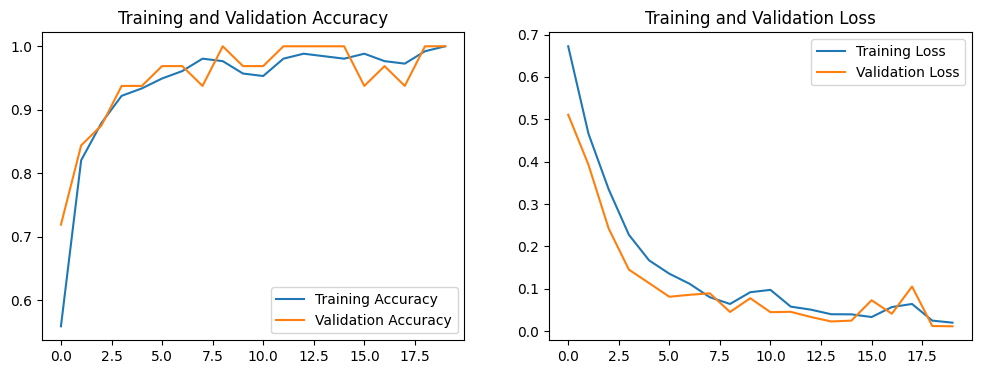

In [18]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()